# **Algoritmo GrabCut para remoção de fundo baseado em poda de grafos**

- Uso e introdução de um retângulo. Tudo o que estiver fora deste retângulo será considerado como fundo. Tudo o que está dentro do retângulo é desconhecido. 

- O algoritmo rotula os pixéis de primeiro plano e de fundo (ou é feito manualmente)

- Em seguida, um modelo de mistura gaussiana (Gaussian Mixture Model, GMM) é usado para modelar o primeiro plano e o plano de fundo.

- Dependendo dos dados que fornecemos, o GMM aprende e cria uma nova distribuição de pixels. Ou seja, os **pixels desconhecidos são rotulados como provável primeiro plano ou provável plano de fundo**, dependendo de sua relação com os outros pixels com rótulos rígidos em termos de estatísticas de cores (é como um agrupamento).

- Um grafo é criado a partir dessa distribuição de pixels. Os nós nos grafos são pixels. Dois nós adicionais são adicionados, o nó Source e o nó Sink. Cada pixel de primeiro plano é conectado ao nó Source e cada pixel de fundo é conectado ao nó Sink.

- Os pesos das bordas que conectam os pixels ao nó de origem/ao nó final são definidos pela probabilidade de um pixel ser primeiro plano/plano de fundo. Os pesos entre os pixels são definidos pelas informações da borda ou pela similaridade dos pixels. Se houver uma grande diferença na cor do pixel, a borda entre eles terá um peso baixo

- Em seguida, um algoritmo mincut é usado para segmentar o grafo. Ele corta o grafi em dois nós de origem e um nó de destino separados com função de custo mínimo. A função de custo é a soma de todos os pesos das bordas que são cortadas. Após o corte, todos os pixels conectados ao nó Source tornam-se primeiro plano e os conectados ao nó Sink tornam-se plano de fundo.

- O processo continua até a classificação convergir.

![](https://docs.opencv.org/3.4/grabcut_scheme.jpg)

Paper - http://dl.acm.org/citation.cfm?id=1015720

Learn more - https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html

In [1]:
import cv2
import dlib
import sys
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def imshow(titulo = 'Image', imagem = None, size = 10):
    w, h = imagem.shape[0], imagem.shape[1]
    aspect_ratio = w/h
    plt.Figure(figsize=(size * aspect_ratio, size))
    plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.show()

(768, 432, 3)
4 303 343 464
(464, 343, 3)


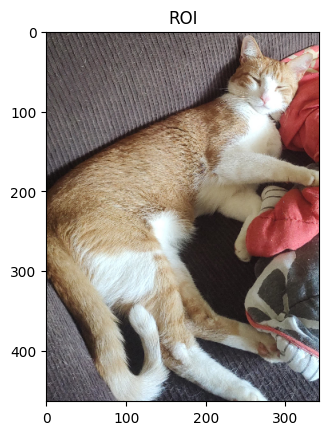

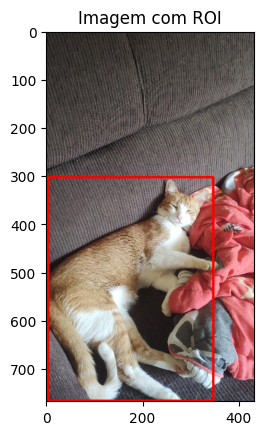

In [3]:
imagem = cv2.imread('../../images/PatricioGatoNenudo.jpg')

# Redimensionar a imagem ( 20% do tamanho original)
scale = 0.2
imagem = cv2.resize(imagem, (int(imagem.shape[1] * scale), int(imagem.shape[0] * scale)))

copia = imagem.copy()

print(copia.shape)

#criando mascara com tamanho da imagem (tudo 0 pq é desconhecido)
mask = np.zeros(imagem.shape[:2], np.uint8)
"""
O GrabCut usa um modelo GMM com 5 distribuições gaussianas para representar os pixels do background e foreground.

Cada modelo GMM tem 5 componentes (ou "clusters")
Cada Gaussiana tem 3 parâmetros que precisam ser armazenados (peso, médias, covariancia)
    - É 1 peso
    - São 3 parametros por gaussiana (RGB)
    - São 3 valores da matriz diagonal por gaussiana 
    1+3+3=7(parametros por Gaussiana)

    Cada modelo tem 5, portanto, 5x7 = 35.

Tendo 2 GMM (pro fundo e pro primeiro plano), temos 70 posições, mas como o openCV remove valores redundantes, 
precisamos ter 65 posições. 

"""
backgroundModel = np.zeros((1,65), np.float64)
foregroundModel = np.zeros((1,65), np.float64)

def getROI(img):
    roi = cv2.selectROI('get ROI',img, showCrosshair=True, fromCenter=False)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    x, y, w, h = roi
    return x, y, w, h

x, y, w, h = getROI(copia)
print(x, y, w, h)
print(np.array(copia[y:y+h, x:x+w]).shape)
roi = copia[y:y+h, x:x+w]
imshow('ROI',roi)

comeco = (x, y)
fim = (w+x, h+y)

rect = (x, y, w+x, h+y)

cv2.rectangle(copia, comeco, (w+x, h+y) , (0, 0 , 255), 3)
imshow('Imagem com ROI', copia)

Dimensões Mask2 (768, 432)
Dimensões Imagem (768, 432, 3)


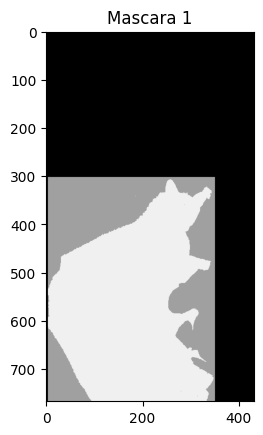

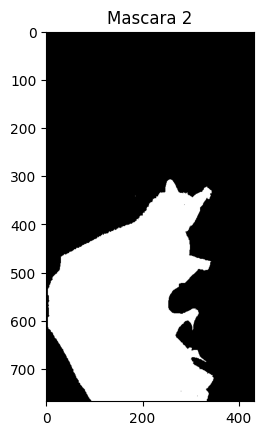

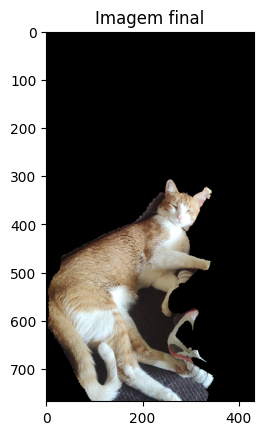

In [14]:
""" 
Deixe o algoritmo ser executado por 5 iterações. O modo deve ser cv.GC_INIT_WITH_RECT, 
pois estamos usando um retângulo. 

o GrabCut modifica as mascaras da imgem

Na nova mascara, pixels irão ser marcados com 4 flags que indicam fundo/primeiro plano, conforme especificado acima.

Portanto, modificamos a máscara de forma que todos os pixels 0 e 2 sejam colocados em 0 
(ou seja, plano de fundo) e todos os pixels 1 e 3 sejam colocados em 1 (ou seja, pixels de primeiro plano). 

Agora, nossa máscara final está pronta. Basta multiplicá-la pela imagem de entrada para obter a imagem segmentada.
"""
cv2.grabCut(imagem, mask, rect, backgroundModel, foregroundModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0), 0,1).astype('uint8')
print("Dimensões Mask2", mask2.shape)
imagem = imagem * mask2[:,:,np.newaxis] #np.newaxis para adicionar mais 1 dimensão, fazendo a mascara ter 1 canal.
#Lembrando imagem x mask2, vai ser 3x1 canais
print("Dimensões Imagem", imagem.shape)
imshow('Mascara 1', mask * 80)
imshow('Mascara 2', mask2 * 255)
imshow('Imagem final', imagem)
